[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eldanc/mlbootcamp2023/blob/main/lab_1_2_svms.ipynb)

# UofT FASE ML Bootcamp
#### Monday, June 19, 2023
#### Support Vector Machines - Lab 2, Day 1
#### Teaching team: Eldan Cohen, Alex Olson, Nakul Upadhya, Shehnaz Islam
##### Lab author: Alexander Olson, aolson@mie.utoronto.ca, edited by Jake Mosseri

In this lab, we will extend our work with Scikit-Learn from Lab 1, and look at a range of linear classifiers. Then, we will introduce Support Vector Machines (SVMs), a powerful classifier. In this section, we will develop the intuition behind support vector machines and their use in classification problems. Finally, we will look at linear regression, and introduce the concept of regularizers.

We begin with some standard imports and installation of the packages that will be used

In [1]:
!pip install seaborn
!pip install matplotlib
!pip install scipy
!pip install numpy
!pip install scikit-learn

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# SVMS: Motivation

While the KNN classifier we looked at in the previous lab classifies new samples by their proximity to existing data, here we will be looking at models which draw a _decision boundary_ through the data. This means that we can draw a 'line' through N-dimensional space which separates the classes - everything on one side of the line will be class A, and everything on the other side of the line will be class B. Here's an example:

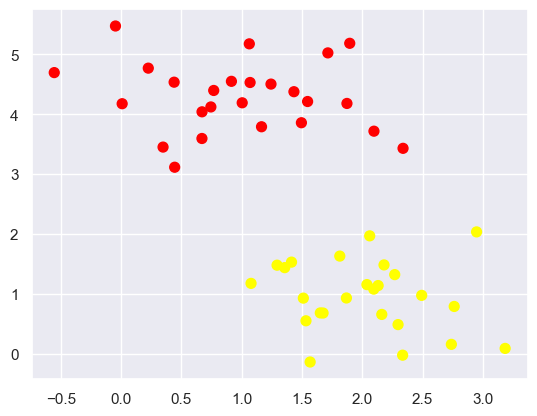

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

It's pretty obvious from looking at this data where the decision boundary should go - at least approximately. But in reality, there are a whole set of potential decision boundaries we could use here! Here are three _very_ different separators which will all perfectly classify the data:

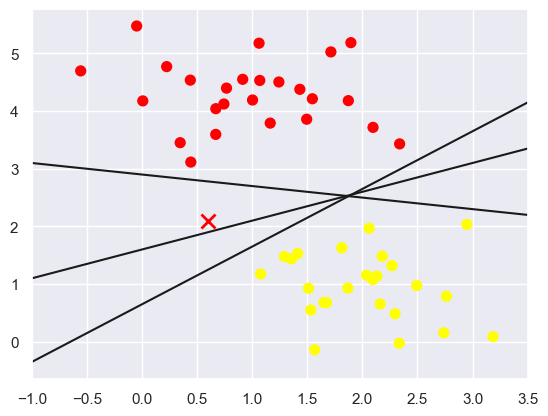

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

# Maximizing the margin

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

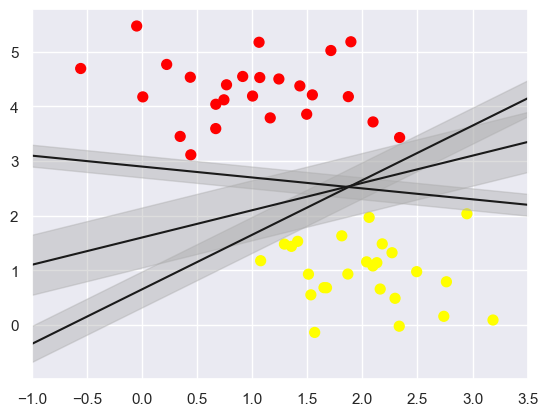

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin (i.e., the thickest grey area) is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

# Fitting an SVM

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. (Remember sklearn's **initialize->fit->predict** pipeline!)

In [6]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear') #initialize

model.fit(X, y) # fit

SVC(kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us (*Note: don't worry about the details of this function too much right now*):

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

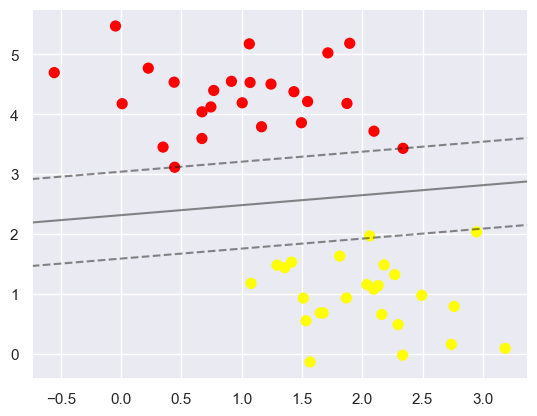

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

# Comparing to Lab 1

Let's bring back our KNN classifier from Lab 1, and compare its performance on a classification task to an SVM. We'll use a wine dataset provided by Scikit-Learn:

In [9]:
from sklearn.datasets import load_wine

wine_data = load_wine()

The data also conveniently comes with a description that we can print out as follows:

In [10]:
print(wine_data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

Excellent! This is just what we needed to understand how to think about and use this data set. The key points:

1.    There are 3 classes (creatively named 'class_0', 'class_1', and 'class_2'). It's likely these correspond to some typical wine varietals like Pinot Noir, or Cabernet, or Merlot...
2.    There are 13 numerical attributes detailing things like alcohol perentage, ash (am I drinking ash in my wine??), Flavanoids, etc.


Let's now try classifying this dataset using the KNN classifier from the previous lab. As a hint, all of the required imports are provided below. If you're stuck, look back on last week to see what to do - just remember we are using `wine_data` now instead of `iris_data`.

**YOUR TURN**

Create a wine classifying KNN with k=1 using the code from the last lab.

* What was the accuracy on the training set? **1.00**
* What was the cross-validation accuracy on the test set? **0.73**

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(wine_data.data, wine_data.target, test_size=0.3, random_state=0)
knn.fit(X_train, y_train)
print(f'Training accuracy:         {knn.score(X_train, y_train):.2f}')
print(f'Test accuracy:             {knn.score(X_test, y_test):.2f}')
print(f'Cross-validation accuracy: {cross_val_score(knn, wine_data.data, wine_data.target, cv=5).mean():.2f}')

Training accuracy:         1.00
Test accuracy:             0.76
Cross-validation accuracy: 0.73


In [12]:
def prepared_data_lab2():
    wine_data = load_wine()
    feature_data = wine_data.data
    target_data = wine_data.target
    target_names = wine_data.target_names
    return train_test_split(feature_data, target_data, test_size=0.3, random_state=0)

def report_model_score(data, model, report=True):
    scores = cross_val_score(model, data[0], data[1], cv=5)
    if report:
        print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores.mean()

You should notice that, even though we saw this classifier attain 97% accuracy last time, on this task performance is a lot worse. So let's bring in an SVM and see how well it performs:

In [13]:
X_train, X_test, y_train, y_test = prepared_data_lab2()
model = SVC(kernel='linear')
model.fit(X_train, y_train); #Note: adding a semicolon to the end of the line will prevent Jupyter from printing output!

report_model_score(data=(X_test, y_test), model=model);

CV Accuracy: 0.89 (+/- 0.07)


This is dramatically higher! This is the power of SVMs. By identifying the _maximum margin_, they ensure not only _good_ but _optimal_ classification.

# Non-linear problems: Kernel SVM

We've established why SVMs are (often) better than standard linear classifiers, and also that they can perform better than a model we've seen before. But so far we have only looked at data we can _linearly separate_: that is to say, we can draw a straight line between the classes. What happens when there is a clear separation, but it's non-linear? Here's an example:

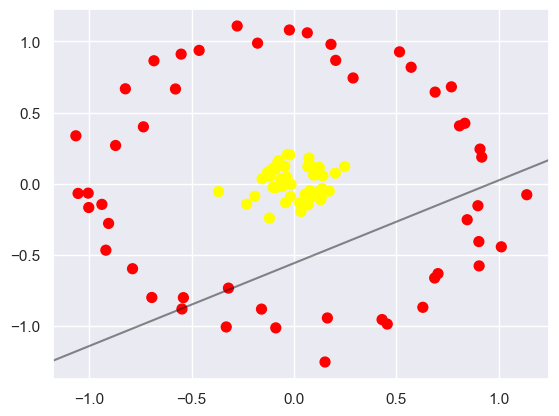

In [14]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Our SVM performs terribly here, to nobody's surprise. This data is absolutely not linearly separable! However, it's obvious to us how it _can_ be separated. The pattern is very clear! How can we get SVMs to approach this? It's simple. By _projecting_ the data into a different space, we can transform it in such a way that the information here is preserved, but we gain linear separability. To do this, we can introduce a _radial basis function_. This calculates the distance at any point from the centre of a circle.

In [15]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot:

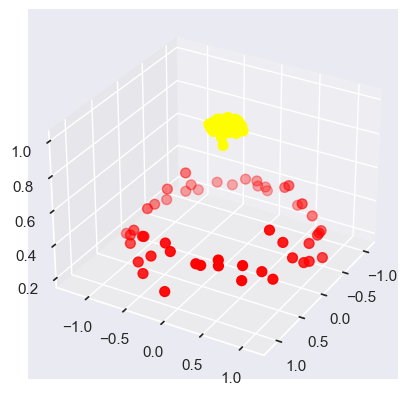

In [16]:
from mpl_toolkits import mplot3d
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=30, azim=30)

We can see that with this additional dimension, the data becomes trivially linearly separable.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting N points into N dimensions—is that it might become very computationally intensive as N grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full N-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

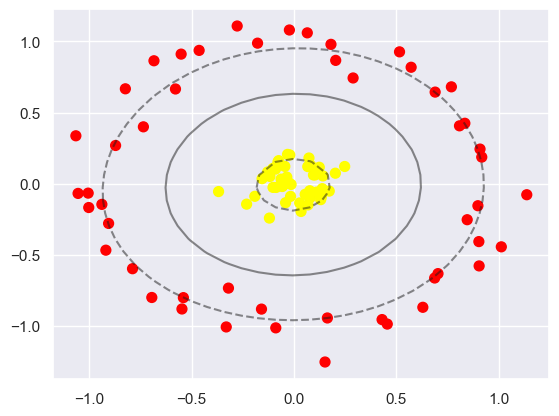

In [17]:
clf = SVC(kernel='rbf', gamma='auto')
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Voila! The seperator is much nicer using the RBF kernel, as required.

# Regression: Introduction

The models we have looked at so far all fall under the umbrella term of _classification_. That is to say, these models take in some input data and return the predicted _class_ that data falls under. But there is another core type of model which we are yet to look at: _regression_ models.

Regression models take in some input value X, but instead of returning an expected class they output another numerical value. This is important because in some problems we don't want to limit ourselves to _discrete_ classes - think about the difference between a model which predicts a person's age, and a model which predicts the generation someone was born in.

**YOUR TURN**

* What is an example of a problem that should be solved using a _classifier_? **Predicting whether a patient has a disease or not**
* What is an example of a problem that should be solved using a _regressor_? **Predicting the price of a house**

# Regression: Ordinary Least Squares

One of the simplest regression models we will look at is Ordinary Least Squares (OLS), a type of linear regressor. OLS fits a linear model with coefficients $w = (w_1..w_p)$ to minimize the _residual sum of squares_ between the observed targets in the dataset, and the targets predicted by the regressor. That is to say, the objective of the model is to minimize the difference between the predicted and actual value for each training point, squared. This is represented mathematically by the _cost function_ below: $$min_w||Xw-y||^2_2$$

The subscript 2 refers to the fact that this computation is using L2 norm - for now, we will skip this, but it essentially refers to calculating the Euclidean distance between $Xw$ and $y$. The superscript 2 refers to the fact that this cost term is squared.

Let's now take two loosely correlated features from the wine dataset and plot them. We will use alcohol level and color intensity for our first regressor.

In [18]:
alcohol = wine_data.data[:,wine_data.feature_names.index('alcohol')]
color = wine_data.data[:,wine_data.feature_names.index('color_intensity')]

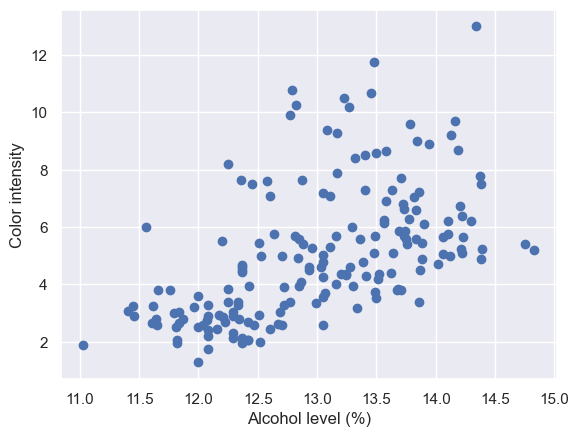

In [19]:
plt.scatter(alcohol,color)
plt.xlabel('Alcohol level (%)')
plt.ylabel('Color intensity');

In [20]:
  def train_test_split_1d(feature_data, target_data, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    return X_train.reshape(-1,1), X_test.reshape(-1,1), y_train, y_test

In [21]:
from sklearn import linear_model

reg = linear_model.LinearRegression() #intialize

X_train,X_test,y_train,y_test = train_test_split_1d(alcohol,color,test_size=0.3,random_state=0)

In [22]:
reg.fit(X_train,y_train); # fit

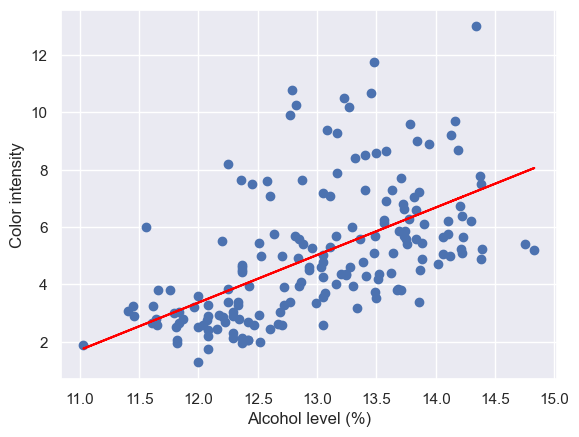

In [23]:
plt.scatter(alcohol,color)
plt.xlabel('Alcohol level (%)')
plt.ylabel('Color intensity');
plt.plot(alcohol, [(t * reg.coef_[0]) + reg.intercept_ for t in alcohol],c='red');

The red line here represents the prediction our model makes at each alcohol level. As you can see, although it does follow the general trend of the data, some of the data points are very far off the line.

Although it is technically possible to use our previous scoring methods to calculate the performance of this model, those scoring methods are designed for classification tasks and not for regression. Here, we should score our model using metrics better suited to the type of task. We will look at two: Mean Squared Error, and R-squared.

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, reg.predict(X_test)):.2f}")
print(f"R-Squared Score:          {r2_score(y_test, reg.predict(X_test)):.2f}")

Mean Squared Error (MSE): 3.81
R-Squared Score:          0.24


R-Squared and MSE report two different ways of looking at the model's error. MSE is quite close to the loss function that OLS uses to fit the model in the first place - it calculates the average squared difference between the predicted value of the model, and the true target value. R-Squared, on the other hand, represents how closely the data conforms to the line we have calculated.

Now that we have an intuition for how OLS works, let's expand from two dimensions to the full 13 dimensions available in the wine dataset. We will use 12 of the dimensions to predict one of the dimensions: alcohol percentage.

**YOUR TURN** Initialise a Linear Regression model, as above, fit the model to the 12 dimensions which are not `alcohol`, and then calculate the mean squared error and R-squared score on a testing set.

* What was the MSE? **0.38**
* What was the R-Squared Score? **0.46**
* Did the model perform well or poorly? Why? **The model performed poorly because the R-Squared score is close to 0.5, which means that the model is not a good fit for the data.**

In [27]:
### Your code here
lr = linear_model.LinearRegression()
alcohol_target = wine_data.data[:,wine_data.feature_names.index('alcohol')]
feature_data = wine_data.data[:,wine_data.feature_names.index('alcohol')+1:]
X_train,X_test,y_train,y_test = train_test_split(feature_data,alcohol_target,test_size=0.3,random_state=0)
lr.fit(X_train,y_train)
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, lr.predict(X_test)):.2f}")
print(f"R-Squared Score:          {r2_score(y_test, lr.predict(X_test)):.2f}")

Mean Squared Error (MSE): 0.38
R-Squared Score:          0.46


# Regularization, and ridge regression

Finally, we are going to look at one other type of linear regression model: Ridge regression. OLS has a fundamental flaw, which is that it can _overfit_ to the training data. This means that aspects of the data which are in fact noise can become built into the prediction, causing errors when making new predictions that have different noise.

Ridge regression addresses this issue by adding a _regularisation_ term to the cost function:

$$min_w||Xw-y||^2_2 + \big(\lambda * ||w||^2_2\big)$$

The regularisation term is on the right. This forces the model to minimize not just the prediction error, but also the size of the weights. But why do we want this? You may be familiar with the concept of Occam's razor. This principle says that whenever you have more than one possible explanation for a phenomenon, you should prefer the simplest explanation. Regularization enables us to encode this principle mathematically - a simpler explanation, even one that is technically worse on the training data, is preferred over a more complex solution which may be making too many assumptions. This helps us to _generalize_ to unseen data, by making as few assumptions as possible from our training set.

The $\lambda$ here dictates how important the regularisation term is to the cost function. Set it to zero, and the regularizer is ignored - our weights can be as big as the model could possibly dream of. Set it _too_ high, however, and the model will care more about keeping the weights small than it will about getting good performance. A healthy balance is required, and differs between different problems.

If the weights that are calculated by the model are _parameters_, then we refer to weights like $\lambda$ - which are set by us and not the model - as _hyper-parameters_. Hyper-parameter tuning is an important part of developing a model, and can make massive improvements in performance if done well.

# Acknowledgements

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

https://jonathonbechtel.com/blog/2018/02/06/wines/